# 1. Data input

### 1.1 Read the metadata table (clusters_df): strain name and paths of their mortality data .pickles

In [113]:
import os, pandas
%cd '/app/src/ms2_post_analysis'
from math import isnan
csv_df = pandas.read_csv('Github Links MS2 - Sheet1.csv',sep=',')
#clusters_df = csv_df.drop([0])
clusters_df = csv_df
clusters_df = clusters_df.iloc[:,:]
clusters_df.columns = ['genotype','url','cluster', 'Obs','Unnamed','Unnamed']
clusters_df = clusters_df[clusters_df['url']!='in progress']
clusters_df = clusters_df[clusters_df['url'].isnull()==False]

to_drop = []
import urlparse, urllib
from os import path
for i in range(len(clusters_df)):
    url_parsed = urlparse.urlparse(clusters_df.iloc[i]['url'])
    relative_path = urllib.unquote('/'.join(url_parsed.path.split('/')[5:])).decode('utf8')
    clusters_df.loc[clusters_df.index[i], 'path'] = relative_path
    strain_name = url_parsed.path.split('/')[-1]
    if isnan(clusters_df.loc[clusters_df.index[i], 'cluster']):
        print "not fit GG or GGM",strain_name
        to_drop.append(i)
        continue
    clusters_df.loc[clusters_df.index[i], 'strain'] = strain_name
    clusters_df.loc[clusters_df.index[i], 'cluster'] = str(int(clusters_df.loc[clusters_df.index[i], 'cluster']))

clusters_df = clusters_df.drop(to_drop)

/app/src/ms2_post_analysis
not fit GG or GGM alr
not fit GG or GGM atoS
not fit GG or GGM hybG


### 1.2 Locate mortality clusters

In [114]:
%cd '/app/src/ms2'

/app/src/ms2


In [115]:
import re
to_drop = []
for ind in clusters_df.index:
    #print clusters_df.loc[ind]['path']
    try:
        re_mortality1 = re.compile('(.*) mortality_dataframe_cluster(\d).pickle')
        re_mortality2 = re.compile('(.*)_mortality_dataframe_cluster(\d).pickle')
        re_mortality = re.compile('(.*?.)mortality_dataframe_cluster(\d).pickle')
        matches1 = [fn for fn in os.listdir(clusters_df.loc[ind,'path']) if re.match(re_mortality1, fn)]
        matches2 = [fn for fn in os.listdir(clusters_df.loc[ind,'path']) if re.match(re_mortality2, fn)]
        matches = (matches1, matches2)[len(matches1) == 0]
        if len(set([re.match(re_mortality, fn).groups()[0] for fn in matches]))>1:
                raise Exception(matches)
        if len(matches) < int(clusters_df.loc[ind,'cluster']):
            raise Exception(matches.__str__)
        basename = re.match(re_mortality, matches[0]).groups()[0]
        clusters_df.loc[ind, 'basename'] = basename
    except:
        to_drop.append(ind)
print to_drop
clusters_df = clusters_df.drop(to_drop)        


[]


In [116]:
from os import path
for ind in clusters_df.index:
    re_mortality = re.compile(clusters_df.loc[ind, 'basename']+'mortality_dataframe_cluster'+'\d'+'.pickle')
    matches = [fn for fn in os.listdir(clusters_df.loc[ind,'path']) if re.match(re_mortality, fn)]
    if len(matches)-1 < int(clusters_df.loc[ind,'cluster']):
        print 'Droped: ',clusters_df.loc[ind,'path'], matches, clusters_df.loc[ind,'cluster']
        clusters_df.drop(ind,inplace=True)
        

Droped:  dataset/MS 2 Github data part 4/agaA 2 [u'CR-TA_agaA 2-1_mortality_dataframe_cluster0.pickle'] 1


### 1.4 Drop data known to not fit GGM

### 1.5 Load mortality .pickles (pip install pandas==0.19.2)

In [117]:
import pickle
import numpy as np
import pandas as pd
#from Df_timegrid import Df_timegrid
dfs_mortality = dict()
tgs_mortality = dict()
for ind in clusters_df.index:
    fn_mortality = path.join(clusters_df.loc[ind,'path'], clusters_df.loc[ind,'basename']+'mortality_dataframe_cluster'+clusters_df.loc[ind,'cluster']+'.pickle' )
    fn_timegrid = path.join(clusters_df.loc[ind,'path'], clusters_df.loc[ind,'basename']+'relative_timegrid_cluster'+clusters_df.loc[ind,'cluster']+'.pickle' )
    dfs_mortality[clusters_df.loc[ind,'strain']] = pickle.load( open(fn_mortality, 'rb') )
    tg = pickle.load( open(fn_timegrid, 'rb') )
    tgs_mortality[clusters_df.loc[ind,'strain']] = np.array(pd.Series(tg)[tg<=np.max(dfs_mortality[clusters_df.loc[ind,'strain']]['mortality'])])

# 2. Redo statistical mortality analysis and quality control

### 2.1 Fit to GG or GGM

In [176]:
%cd '/app/src/ms2_post_analysis'
from cohortMortalitySummary import GGMfit, GGfit
GGM_fitted = dict()
GG_fitted = dict()
Fitted = dict()
for ind in clusters_df.index:
    GGM_fitted[clusters_df.loc[ind,'strain']] = GGMfit(dfs_mortality[clusters_df.loc[ind,'strain']])
    try:
        GG_fitted[clusters_df.loc[ind,'strain']] = GGfit(dfs_mortality[clusters_df.loc[ind,'strain']])
        if GG_fitted[clusters_df.loc[ind,'strain']]['AIC'] < GGM_fitted[clusters_df.loc[ind,'strain']]['AIC']:
            Fitted[clusters_df.loc[ind,'strain']] = GG_fitted[clusters_df.loc[ind,'strain']]
            Fitted[clusters_df.loc[ind,'strain']]['type'] = 'GG'
            print clusters_df.loc[ind,'strain'] + ': GG'
        else:
            Fitted[clusters_df.loc[ind,'strain']] = GGM_fitted[clusters_df.loc[ind,'strain']]
            Fitted[clusters_df.loc[ind,'strain']]['type'] = 'GGM'
            print clusters_df.loc[ind,'strain'] + ': GGM'
    except:
        Fitted[clusters_df.loc[ind,'strain']] = GGM_fitted[clusters_df.loc[ind,'strain']]
        Fitted[clusters_df.loc[ind,'strain']]['type'] = 'GGM'
        print clusters_df.loc[ind,'strain'] + ': GGM'

/app/src/ms2_post_analysis
agaR: GG
agaV: GG
alsB: GG
appA: GG
appB: GGM
MG%20appY: GGM
aqpZ2: GGM
ascG2: GGM
bglF: GG
bipA: GG
caiB: GGM
caiC: GGM
caiT: GGM
casE%202: GGM
cbpM: GG
citT: GGM
crcA: GG
cstA: GG
cynX: GG
dcp: GG
dcuA: GGM
dnaT: GGM
eptA: GG
eutQ: GG
fabR%202: GGM
fixC: GGM
fkpA: GG
flgD%202: GGM
flu: GG
fruB: GG
fruR: GG
fsr: GGM
glf: GG
glpX: GGM
gltD: GG
gltK: GGM
gltL: GG
gnsA: GGM
gspF: GGM
gspL: GGM
gspM: GGM
hslR2: GGM
hycA: GG
idnD: GGM
intG: GGM
ldcC: GG
lsrC: GG
lysC%202: GGM
melA: GGM
mhpB: GGM
mprA: GGM
mtlD: GG
nagK: GG
nagZ: GG
napC: GGM
nirC: GGM
norV: GGM
norW: GGM
nsrR: GGM
ompL2: GGM
osmY: GG
paaC: GGM
paoB: GGM
pfkA: GG
pflC: GG
pflD: GG
pgi3: GGM
phnH: GG
ptsH: GG
rarD%202: GGM
recF: GG
rph: GGM
rsd: GGM
sgcQ: GGM
sspA: GGM
ssuA: GGM
ssuE%202: GGM
syd: GGM
tdcE: GGM
70%20thiQ: GG
treC: GG
tyrB: GG
ulaD: GGM
uxaA: GGM
uxaB2: GGM
uxaC3: GGM
uxuR3: GGM
MG-WT: GGM
xdhB: GGM
xdhC: GG
yafV: GG
yafX: GG
yagH: GGM
yagL: GG
yagQ: GG
80%20MG%20yagS: GG
yajQ%202: 

In [177]:
import dill
dill_file = open("dill/Fitted.p", "wb")
dill_file.write(dill.dumps(Fitted))
dill_file.close()

import dill
dill_file = open("dill/dfs_mortality.p", "wb")
dill_file.write(dill.dumps(dfs_mortality))
dill_file.close()

import dill
dill_file = open("dill/tgs_mortality.p", "wb")
dill_file.write(dill.dumps(tgs_mortality))
dill_file.close()

import dill
dill_file = open("dill/quantiles.p", "wb")
dill_file.write(dill.dumps(quantiles))
dill_file.close()

import dill
dill_file = open("dill/KStests.p", "wb")
dill_file.write(dill.dumps(KStests))
dill_file.close()

import dill
dill_file = open("dill/stats.p", "wb")
dill_file.write(dill.dumps(stats))
dill_file.close()

In [ ]:
%cd '/app/src/ms2'
import dill
dill_file = open("dill/Fitted.p", "rb")
Fitted_from_file = dill.load(dill_file)
dill_file.close()
Fitted = Fitted_from_file

dill_file = open("dill/stats.p", "rb")
stats_from_file = dill.load(dill_file)
dill_file.close()
stats = stats_from_file

dill_file = open("dill/dfs_mortality.p", "rb")
dfs_from_file = dill.load(dill_file)
dill_file.close()
dfs_mortality = dfs_from_file

dill_file = open("dill/tgs_mortality.p", "rb")
tgs_from_file = dill.load(dill_file)
dill_file.close()
tgs_mortality = tgs_from_file

dill_file = open("dill/KStests.p", "rb")
KStests_from_file = dill.load(dill_file)
dill_file.close()
KStests = KStests_from_file

### 2.2 Generate bootstrapped statistics: Medians, GGM parameters

In [8]:
#%cd '/app/src/ms2_post_analysis'
from cohortMortalitySummary import rflexsurv, globalenv, ro, pandas2ri
import numpy as np
import os
flexsurvreg = rflexsurv.flexsurvreg
normboot = rflexsurv.normboot_flexsurvreg
ro.r.source(os.path.join( 'Rmodels', 'GammaGompertz.R'), echo=False,verbose=False);
ro.r.source(os.path.join( 'Rmodels', 'GammaGompertzMakeham.R'), echo=False,verbose=False);
qgammagompertz = globalenv['qgammagompertz']
pgammagompertzmakeham = globalenv['pgammagompertzmakeham']
def gg_med(para):
    return np.array(qgammagompertz(0.5,
                        para['beta'],
                        para['s'],
                        para['rate']))[0]

def ggm_med(para, precision=0.1, max_t = 150):
    ptime = np.arange(0,max_t,precision)
    rtime = ro.Vector(ptime)
    probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
    while probs[-1]<0.5:
        ptime = np.arange(max_t, max_t+100, precision)
        rtime = ro.Vector(ptime)
        probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
        max_t += 100
    return ptime[probs>=0.5][0]
    

In [9]:
import pandas as pd
stats = dict()
strain_error = []
for strain in Fitted.keys():
    print strain
    try:
        paras = pandas2ri.ri2py(normboot(Fitted[strain]['flexsurvreg'],B=50000))
        if Fitted[strain]['type'] == 'GGM':
            stats[strain]=pd.DataFrame(data=paras,columns=['rate','beta','s','lambda'])
        elif Fitted[strain]['type'] == 'GG':
            stats[strain]=pd.DataFrame(data=paras,columns=['beta','s','rate'])
            stats[strain]['lambda'] = pd.Series([0]*len(paras))
        meds = [(ggm_med(dict(stats[strain].iloc[i,:])), gg_med(dict(stats[strain].iloc[i,:])))[Fitted[strain]['type'] == 'GG'] for i in range(len(paras))]
        stats[strain]['median'] = pd.Series(data=meds)
    except:
        #paras = pandas2ri.ri2py(normboot(Fitted[strain]['flexsurvreg'],B=50000))
        print "error ", strain
        strain_error.append(strain)
        
        
        

yihV%202
norW
norV
yncI
yecP
bipA
pgi3
nirC
80%20MG%20yagS
ssuE%202
yoaF
ycaL
ulaD
ycaD
nagZ
sspA
nagK
ydjQ
error  ydjQ
MG-WT


/app/miniconda/envs/py27/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in (function (x, B, newdata = NULL, X = NULL, transform = FALSE,  : 
  Covariance matrix not available from non-converged model

  warnings.warn(x, RRuntimeWarning)


lsrC
yfbM
ptsH
osmY
ydjK
flgD%202
pfkA
dnaT
yjeL
gspF
yfjO
gspL
gspM
paoB
yagQ
ybdG
mprA
ybiT
fruR
ldcC
ynaA
tyrB
yehA
fruB
melA
phnH
ybaJ
ybdK
ytfF
ytfL
cbpM
uxuR3
caiT
yobH
MG%20appY
dcuA
bglF
lysC%202
yhbW
caiC
caiB
yhbS
dcp
gnsA
yicM
recF
ygjP
glf
mhpB
gltK
gltL
casE%202
fixC
gltD
ybbP
zapE
yggE
yggF
citT
yphG
napC
rph
yjfF%202
appB
appA
yjfJ
intG
yjfL
hslR2
pflD
pflC
aqpZ2
ykfF
ybgD
yajQ%202
ykfI
yjhG
rsd
treC
uxaB2
agaR
yicH
agaV
yhdX
yihS
tdcE
70%20thiQ
hycA
yiaW
yjgB
flu
yfiD2
yiaG
eutQ
ompL2
uxaC3
yqjE
crcA
ydcP
alsB
xdhB
xdhC
yagH
yidH
ydgT
yjfC
fkpA
ygcQ%202
eptA
cynX
syd
fabR%202
ascG2
ygfO
paaC
yhbP
yagL
idnD
nsrR
sgcQ
mtlD
ssuA
ycfX
yeeW
rarD%202
cstA
glpX
yigL
fsr
yafX
uxaA
yafV
yigZ


In [10]:
pd.DataFrame(data=paras,columns=['rate','beta','s','lambda'])

,rate,beta,s,lambda
0,0.143737,4.329449e+07,0.436970,0.000983
1,0.108932,1.124965e+06,0.795944,0.000968
2,0.135570,2.100744e+07,0.568846,0.000969
3,0.143281,3.062404e+07,0.371264,0.001388
4,0.117950,2.604707e+06,0.624546,0.001285
5,0.115003,1.970094e+06,0.670389,0.001124
6,0.124542,9.272023e+06,0.747297,0.000864
7,0.128941,1.000351e+07,0.512906,0.001174
8,0.136196,2.098191e+07,0.475231,0.001149
9,0.135946,2.107076e+07,0.475507,0.000983


In [11]:
strain_error

['ydjQ']

### 2.3 Goodness-of-fit by K-S statistics & quality control

In [119]:
from cohortMortalitySummary import KSm_gof, KSm_test
KStests = dict()
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    data = dfs_mortality[strain]
    rtg = tgs_mortality[strain]
    sf = Fitted[strain]['ML_survivorship']
    residues = KSm_gof(data, rtg, sf)
    KStests[strain] = KSm_test(residues[0], residues[1], alpha=0.01)

jump  ydjQ


### These data cross K-S thresholds, but only in very few time points, thus pass quality control

In [13]:
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    if KStests[strain][0] > 1.517:
        print strain, KStests[strain]

norV KstestResult(statistic=1.527911284934915, pvalue=0.01839849899610042, critical_stat=1.6252092349398386)
nirC KstestResult(statistic=1.7289123308911913, pvalue=0.005040075643902505, critical_stat=1.6265198739662754)
80%20MG%20yagS KstestResult(statistic=1.870992574195027, pvalue=0.001821528591744746, critical_stat=1.627623630718729)
jump  ydjQ
lsrC KstestResult(statistic=1.5368317953087949, pvalue=0.017764436786035488, critical_stat=1.627623630718729)
ptsH KstestResult(statistic=1.7420232174035264, pvalue=0.004625630469956536, critical_stat=1.627623630562672)
paoB KstestResult(statistic=1.8582398962413964, pvalue=0.0020032912150882856, critical_stat=1.627623630718729)
ybiT KstestResult(statistic=1.541906921696143, pvalue=0.01709971502820946, critical_stat=1.6268235536213937)
fruR KstestResult(statistic=1.525101053600419, pvalue=0.019087544695554546, critical_stat=1.627623630718729)
fruB KstestResult(statistic=2.0712406519531825, pvalue=0.0003756215279743861, critical_stat=1.6276236

### Mortality cluster with too few imaging positions, dropped later

In [14]:
for strain in dfs_mortality.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    if len(np.unique(dfs_mortality[strain]['fn'])) < 3:
        print strain

ycaD
jump  ydjQ
gspM
mprA
ynaA
melA
MG%20appY
dcuA
bglF
gnsA
gltK
yjfJ
hslR2
ybgD
70%20thiQ
uxaC3
alsB
xdhC
ydgT
syd
yagL
ycfX
glpX
uxaA


### 2.4 Important Quantiles

In [15]:
def gg_q(q, para):
    return np.array(qgammagompertz(q,
                        para['beta'],
                        para['s'],
                        para['rate']))[0]

def ggm_q(q, para, precision=0.1, max_t = 150):
    ptime = np.arange(0,max_t,precision)
    rtime = ro.Vector(ptime)
    probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
    while probs[-1]<q:
        ptime = np.arange(max_t, max_t+100, precision)
        rtime = ro.Vector(ptime)
        probs = np.array(pgammagompertzmakeham(rtime,para['rate'],
                                            para['beta'],
                                            para['s'],
                                            para['lambda']))
        max_t += 100
    return ptime[probs>=q][0]
quantiles = dict()
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    print strain+': '+Fitted[strain]['type']
    paras = pandas2ri.ri2py(normboot(Fitted[strain]['flexsurvreg'],B=5000))
    if Fitted[strain]['type'] == 'GGM':
        quantiles[strain]=pd.DataFrame(data=paras,columns=['rate','beta','s','lambda'])
    elif Fitted[strain]['type'] == 'GG':
        quantiles[strain]=pd.DataFrame(data=paras,columns=['beta','s','rate'])
        quantiles[strain]['lambda'] = pd.Series([0]*len(paras))
    for q in [0.1,0.25,0.5,0.75,0.9]:
        #print q
        qs = [(ggm_q(q, dict(quantiles[strain].iloc[i,:])), gg_q(q,dict(quantiles[strain].iloc[i,:])))[Fitted[strain]['type'] == 'GG'] for i in range(len(paras))]
        quantiles[strain]['q='+str(q)] = pd.Series(data=qs, index=quantiles[strain].index)

yihV%202: GGM
norW: GGM
norV: GGM
yncI: GG
yecP: GG
bipA: GG
pgi3: GGM
nirC: GGM
80%20MG%20yagS: GG
ssuE%202: GGM
yoaF: GG
ycaL: GG
ulaD: GGM
ycaD: GG
nagZ: GG
sspA: GGM
nagK: GG
jump  ydjQ
MG-WT: GGM
lsrC: GG
yfbM: GGM
ptsH: GG
osmY: GG
ydjK: GGM
flgD%202: GGM
pfkA: GG
dnaT: GGM
yjeL: GGM
gspF: GGM
yfjO: GGM
gspL: GGM
gspM: GGM
paoB: GGM
yagQ: GG
ybdG: GGM
mprA: GGM
ybiT: GGM
fruR: GG
ldcC: GG
ynaA: GGM
tyrB: GG
yehA: GGM
fruB: GG
melA: GGM
phnH: GG
ybaJ: GGM
ybdK: GG
ytfF: GGM
ytfL: GG
cbpM: GG
uxuR3: GGM
caiT: GGM
yobH: GGM
MG%20appY: GGM
dcuA: GGM
bglF: GG
lysC%202: GGM
yhbW: GGM
caiC: GGM
caiB: GGM
yhbS: GGM
dcp: GG
gnsA: GGM
yicM: GGM
recF: GG
ygjP: GGM
glf: GG
mhpB: GGM
gltK: GGM
gltL: GG
casE%202: GGM
fixC: GGM
gltD: GG
ybbP: GGM
zapE: GG
yggE: GG
yggF: GGM
citT: GGM
yphG: GGM
napC: GGM
rph: GGM
yjfF%202: GGM
appB: GGM
appA: GG
yjfJ: GG
intG: GGM
yjfL: GG
hslR2: GGM
pflD: GG
pflC: GG
aqpZ2: GGM
ykfF: GG
ybgD: GGM
yajQ%202: GGM
ykfI: GGM
yjhG: GGM
rsd: GGM
treC: GG
uxaB2: GGM
ag

# 3. Aging parameters basics: first figures

### 3.1 Set basic info for plotting: strain aging parameters dataframe (strain_df) and strain categories

In [16]:
strain_df = pd.DataFrame(index=Fitted.keys(), columns=['med_exp','med_model','scale','med_ratio','scale_ratio'])
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    strain_df.loc[strain,'med_model'] = float(np.median(stats[strain]['median']))
    strain_df.loc[strain,'med_ratio'] = float(np.median(stats[strain]['median'])/np.median(stats['MG-WT']['median']))
    strain_df.loc[strain,'scale'] = float(1/Fitted[strain]['model_paras'].loc['rate','est'])
    strain_df.loc[strain,'scale_ratio'] = float(Fitted['MG-WT']['model_paras'].loc['rate','est']/Fitted[strain]['model_paras'].loc['rate','est'])
    strain_df.loc[strain,'rate'] = Fitted[strain]['model_paras'].loc['rate','est']
    strain_df.loc[strain,'rate_L95%'] = Fitted[strain]['model_paras'].loc['rate','L95%']
    strain_df.loc[strain,'rate_U95%'] = Fitted[strain]['model_paras'].loc['rate','U95%']
    strain_df.loc[strain,'beta'] = Fitted[strain]['model_paras'].loc['beta','est']
    strain_df.loc[strain,'beta_L95%'] = Fitted[strain]['model_paras'].loc['beta','L95%']
    strain_df.loc[strain,'beta_U95%'] = Fitted[strain]['model_paras'].loc['beta','U95%']
    strain_df.loc[strain,'s'] = Fitted[strain]['model_paras'].loc['s','est']
    strain_df.loc[strain,'s_L95%'] = Fitted[strain]['model_paras'].loc['s','L95%']
    strain_df.loc[strain,'s_U95%'] = Fitted[strain]['model_paras'].loc['s','U95%']
    strain_df.loc[strain,'model type'] = Fitted[strain]['type']
    if Fitted[strain]['type'] == 'GGM':
        strain_df.loc[strain,'lambda'] = Fitted[strain]['model_paras'].loc['lambda','est']
        strain_df.loc[strain,'lambda_L95%'] = Fitted[strain]['model_paras'].loc['lambda','L95%']
        strain_df.loc[strain,'lambda_U95%'] = Fitted[strain]['model_paras'].loc['lambda','U95%']
    elif Fitted[strain]['type'] == 'GG':
        strain_df.loc[strain,'lambda'] = 0
        strain_df.loc[strain,'lambda_L95%'] = 0
        strain_df.loc[strain,'lambda_U95%'] = 0

jump  ydjQ


Text(0,0.5,'relative longevity')

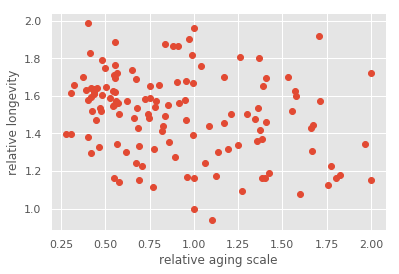

In [149]:
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
#import seaborn as sns
plt.plot(strain_df['scale_ratio'], strain_df['med_ratio'],'o')
#plt.xscale('log')
plt.xlabel('relative aging scale')
#plt.yscale('log')
plt.ylabel('relative longevity')

### 3.2 Aging parameter space: lifespan, aging timescale, shape

__**shape = lifespan / scale**__

In [18]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)
strain_df['scale_ratio_log2'] = [np.log2(float(r)) for r in strain_df['scale_ratio']]
strain_df['lifespan_ratio_log2'] = [np.log2(float(r)) for r in strain_df['med_ratio']]
strain_df['shape_ratio_log2'] = [np.log2(float(r)) for r in strain_df['med_ratio']/strain_df['scale_ratio']]

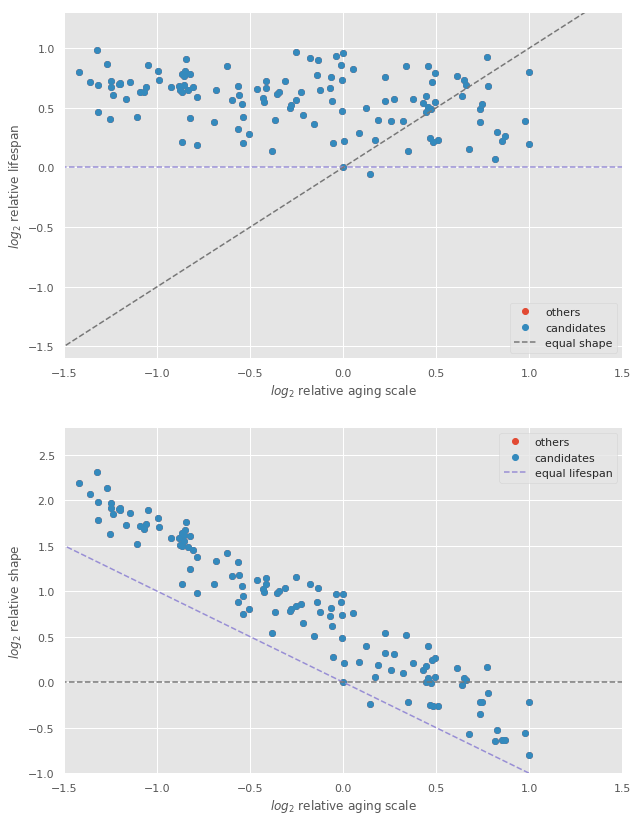

In [150]:
f, (ax1, ax2) = plt.subplots(2, sharex=False)

ax1.plot(strain_df['scale_ratio_log2'], 
         strain_df['lifespan_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'scale_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df['scale_ratio_log2'], 
         strain_df['shape_ratio_log2'],
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'scale_ratio_log2'],
         strain_df.loc[candidates, 'shape_ratio_log2'], 'o', label='candidates')
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-1.5,1.5])
ax1.set_ylim([-1.6,1.3])
ax2.set_ylim([-1,2.8])


f.set_size_inches(10,14)

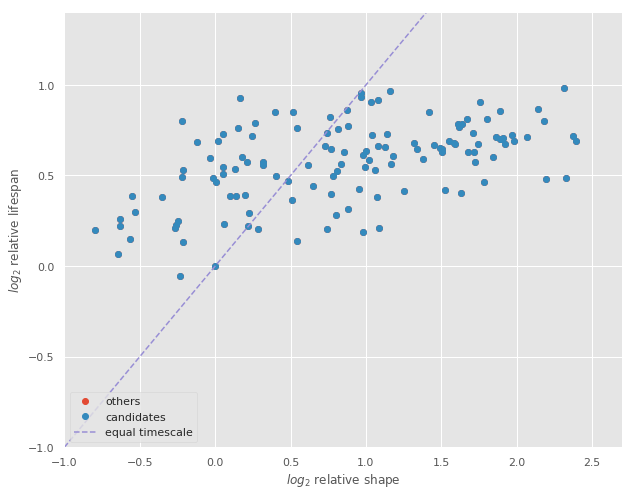

In [151]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df['shape_ratio_log2'], 
         strain_df['lifespan_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'shape_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), '--', label='equal timescale')
ax1.legend(loc=3)

ax1.set_ylim([-1,1.4])
ax1.set_xlim([-1,2.7])


f.set_size_inches(10,8)

### 3.3 Longevity strains as candidate strains

In [21]:
strain_df.loc[candidates,['scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2
yihV%202,0.120459,0.523195,0.402736
norW,-0.599195,0.565141,1.164336
norV,-1.198274,0.711431,1.909705
yncI,0.825763,0.296666,-0.529097
yecP,-0.158954,0.349586,0.508540
bipA,0.084672,0.311873,0.227201
pgi3,-0.824515,0.785495,1.610010
nirC,-0.923854,0.665627,1.589480
80%20MG%20yagS,0.468469,0.219519,-0.248950
ssuE%202,-1.111346,0.411870,1.523216


In [22]:
strain_df.loc[strain_df['lifespan_ratio_log2']>0.4,['scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2
yihV%202,0.120459,0.523195,0.402736
norW,-0.599195,0.565141,1.164336
norV,-1.198274,0.711431,1.909705
pgi3,-0.824515,0.785495,1.610010
nirC,-0.923854,0.665627,1.589480
ssuE%202,-1.111346,0.411870,1.523216
yoaF,0.494770,0.760800,0.266030
ulaD,-0.624050,0.795252,1.419302
ycaD,0.721910,0.440815,-0.281095
nagZ,0.657077,0.677506,0.020429


# 4. Aging parameter C.I.s

### 4.1 Median lifespan: medians estimated non-parametrically from Kaplan-Meier, versus parametrically from GGM

In [23]:
from cohortMortalitySummary import KaplanMeier
def surv_prob_median(surv):
    return (surv.index[surv<0.5][0] + surv.index[surv>0.5][-1])*0.5
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    if KM['upper_ci'].iloc[-1]>0.5:
        print strain
    else:
        strain_df.loc[strain,'med_exp'] = surv_prob_median( KM['survivorship'] )
        strain_df.loc[strain,'med_exp_U95%'] = surv_prob_median( KM['upper_ci'] )
        strain_df.loc[strain,'med_exp_L95%'] = surv_prob_median( KM['lower_ci'] )
    

jump  ydjQ


Text(0,0.5,'model median lifespan (h)')

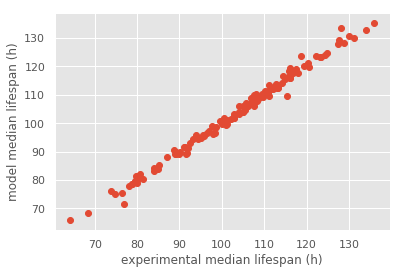

In [152]:
plt.plot([float(r) for r in strain_df['med_model']], strain_df['med_exp'],'o')
plt.xlabel('experimental median lifespan (h)')
plt.ylabel('model median lifespan (h)')


### 4.2 Calculating C.I.s of aging statistics from bootstrapped GGM parameters

In [25]:
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    stats[strain]['smed'] = stats[strain]['median']*stats[strain]['rate']

for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    stats[strain]['inverse_eta'] = stats[strain]['beta']/stats[strain]['s']
    strain_df.loc[strain, 'inverse_eta'] = np.median(stats[strain]['beta']/stats[strain]['s'])
    strain_df.loc[strain,'model_type'] = Fitted[strain]['type']
    strain_df.loc[strain,'shape_exp'] = strain_df.loc[strain,'med_exp']*strain_df.loc[strain,'rate']
    strain_df.loc[strain,'shape_med'] = np.median(stats[strain]['median']*stats[strain]['rate'])
    
    strain_df.loc[strain,'med_model_L95%'] = 0.5*(np.sort(stats[strain]['median'])[int(np.floor(len(stats[strain]['median'])*0.025))]+np.sort(stats[strain]['median'])[1+int(np.floor(len(stats[strain]['median'])*0.025))])
    strain_df.loc[strain,'med_model_U95%'] = 0.5*(np.sort(stats[strain]['median'])[int(np.floor(len(stats[strain]['median'])*0.975))]+np.sort(stats[strain]['median'])[1+int(np.floor(len(stats[strain]['median'])*0.975))])
    
    strain_df.loc[strain,'shape_med_L95%'] = 0.5*(np.sort(stats[strain]['smed'])[int(np.floor(len(stats[strain]['smed'])*0.025))]+np.sort(stats[strain]['smed'])[1+int(np.floor(len(stats[strain]['smed'])*0.025))])
    strain_df.loc[strain,'shape_med_U95%'] = 0.5*(np.sort(stats[strain]['smed'])[int(np.floor(len(stats[strain]['smed'])*0.975))]+np.sort(stats[strain]['smed'])[1+int(np.floor(len(stats[strain]['smed'])*0.975))])
    
strain_df['shape_eta'] = [np.log(s*np.log(2)+1) for s in strain_df['inverse_eta']]

strain_df['scale_ratio_log2'] = [np.log2(float(r)) for r in strain_df['scale_ratio']]
strain_df['scale_ratio_log2_L95%'] = np.log2(strain_df.loc['MG-WT','rate'])-np.log2(strain_df.loc[:,'rate_U95%'])
strain_df['scale_ratio_log2_U95%'] = np.log2(strain_df.loc['MG-WT','rate'])-np.log2(strain_df.loc[:,'rate_L95%'])
strain_df['lifespan_ratio_log2'] = np.log2([lf/strain_df.loc['MG-WT','med_exp'] for lf in strain_df.loc[:,'med_exp']])
strain_df['lifespan_ratio_log2_L95%'] = np.log2(strain_df.loc[:,'med_exp_L95%']/strain_df.loc['MG-WT','med_exp'])
strain_df['lifespan_ratio_log2_U95%'] = np.log2(strain_df.loc[:,'med_exp_U95%']/strain_df.loc['MG-WT','med_exp']) 
strain_df['shape_ratio_log2'] = [np.log2(float(r)) for r in strain_df['med_ratio']/strain_df['scale_ratio']]
strain_df['shape_ratio_log2_L95%'] = np.log2(strain_df.loc[:,'shape_med_L95%']/strain_df.loc['MG-WT','shape_med'])
strain_df['shape_ratio_log2_U95%'] = np.log2(strain_df.loc[:,'shape_med_U95%']/strain_df.loc['MG-WT','shape_med'])

jump  ydjQ
jump  ydjQ


### 4.3 Drop data with too few imaging positions to avoid large C.I.s

In [26]:
for strain in dfs_mortality.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    if len(np.unique(dfs_mortality[strain]['fn'])) < 3:
        print strain
        strain_df.drop(strain, inplace=True)

ycaD
jump  ydjQ
gspM
mprA
ynaA
melA
MG%20appY
dcuA
bglF
gnsA
gltK
yjfJ
hslR2
ybgD
70%20thiQ
uxaC3
alsB
xdhC
ydgT
syd
yagL
ycfX
glpX
uxaA


### 4.4 Classify and plot strains based on significant differences in aging parameters

In [27]:
for strain in strain_df.index:
    for trait in ['rate', 'med_exp', 'shape_med']:
        if strain_df.loc[strain, trait+'_U95%'] < strain_df.loc['MG-WT', trait+'_L95%']:
            strain_df.loc[strain, trait+'_overlap_wt'] = -1
        elif strain_df.loc[strain, trait+'_L95%'] > strain_df.loc['MG-WT', trait+'_U95%']:
            strain_df.loc[strain, trait+'_overlap_wt'] = 1
        else:
            strain_df.loc[strain, trait+'_overlap_wt'] = 0

In [96]:
import seaborn as sns

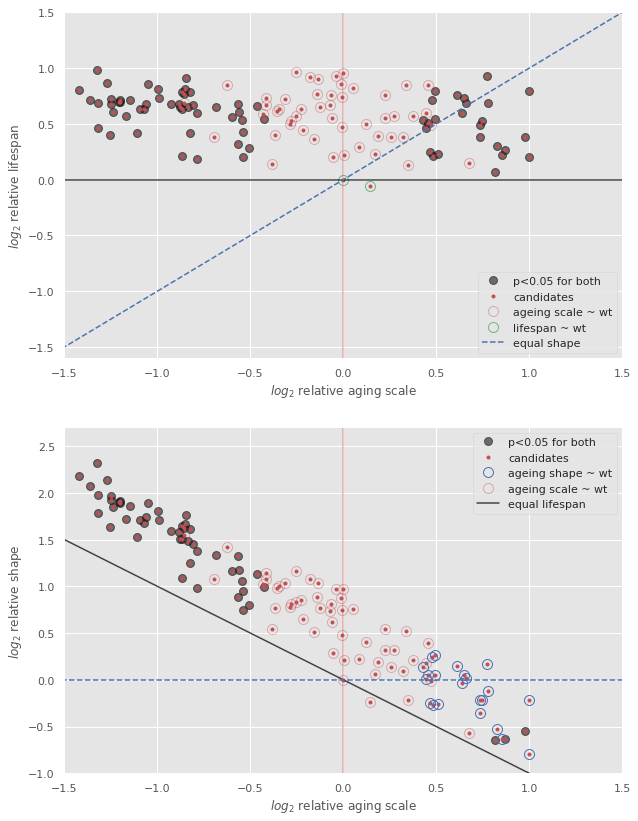

In [153]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)
rate_diff = set(strain_df.index[strain_df['rate_overlap_wt']!=0])
rate_non = set(strain_df.index[strain_df['rate_overlap_wt']==0])
lifespan_diff = set(strain_df.index[strain_df['med_exp_overlap_wt']!=0])
lifespan_non = set(strain_df.index[strain_df['med_exp_overlap_wt']==0])
shape_diff = set(strain_df.index[strain_df['shape_med_overlap_wt']!=0])
shape_non = set(strain_df.index[strain_df['shape_med_overlap_wt']==0])

f, (ax1, ax2) = plt.subplots(2, sharex=False)

ax1.plot(strain_df.loc[set.intersection(rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(rate_diff, lifespan_diff),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.difference(rate_non, lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.difference(rate_non, lifespan_non), 'lifespan_ratio_log2'],
         'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[lifespan_non, 'scale_ratio_log2'],
         strain_df.loc[lifespan_non, 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[set.intersection(shape_diff, rate_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(shape_diff, rate_diff),'shape_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax2.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'shape_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax2.plot(strain_df.loc[set.difference(shape_non, rate_non), 'scale_ratio_log2'],
         strain_df.loc[set.difference(shape_non, rate_non), 'shape_ratio_log2'],
        'o',label='ageing shape ~ wt',markerfacecolor='none', markeredgecolor='b', markersize=10)
ax2.plot(strain_df.loc[rate_non, 'scale_ratio_log2'],
         strain_df.loc[rate_non, 'shape_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '-',color='k', alpha=0.8, label='equal lifespan')
ax2.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--',color='b')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-1.5,1.5])
ax1.set_ylim([-1.6,1.5])
ax2.set_ylim([-1,2.7])


f.set_size_inches(10,14)

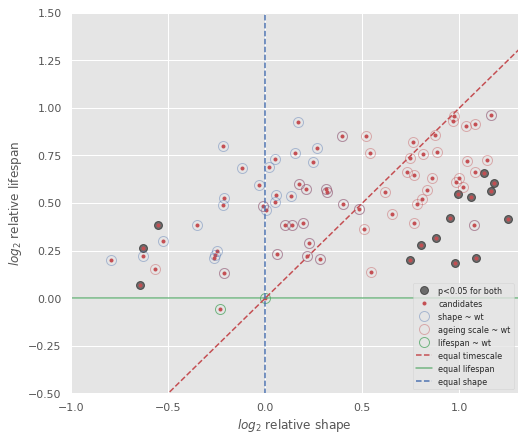

In [154]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.difference(set.intersection(shape_diff, lifespan_diff),rate_non),'shape_ratio_log2'], 
         strain_df.loc[set.difference(set.intersection(shape_diff, lifespan_diff),rate_non),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'shape_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.difference(shape_non, lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.difference(shape_non, lifespan_non), 'lifespan_ratio_log2'],
         'o',label='shape ~ wt',markerfacecolor='none', markeredgecolor='b', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.difference(rate_non,lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.difference(rate_non,lifespan_non), 'lifespan_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[lifespan_non, 'shape_ratio_log2'],
         strain_df.loc[lifespan_non, 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)


ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), 'r--', label='equal timescale')
ax1.plot(np.arange(4,-4,-0.1),[0]*80, '-',color='g', alpha=0.8, label='equal lifespan')
ax1.plot([0]*80,np.arange(4,-4,-0.1),  '--',color='b', label='equal shape')
ax1.legend(loc=4, fontsize=8)

ax1.set_ylim([-0.5,1.5])
ax1.set_xlim([-1,1.3])


f.set_size_inches(8,7)

# 5. What is shape? A function of Gompertz intercept

### 5.1 Analytical formulation of shape using Gamma-Gompertz parameters: $ln(\frac{\beta}{s}ln2+1)$

### 5.2 Analytical vs experimental shape

__Experimental shape could be calculated using lifespan distribution without assuming parametric models__

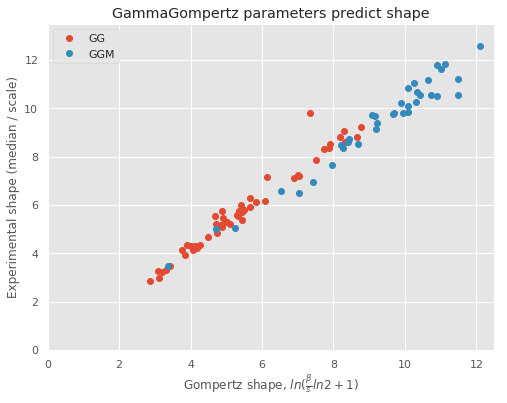

In [155]:
f, ( ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[strain_df['model_type']=='GG','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GG','shape_exp'],'o',label='GG')
ax1.plot(strain_df.loc[strain_df['model_type']=='GGM','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GGM','shape_exp'],'o',label='GGM')
ax1.set_xlabel('Gompertz median')
ax1.set_ylabel('Experimental shape (median / scale)')
ax1.set_xlim([0,12.5])
ax1.set_ylim([0,13.5])
ax1.legend(loc=2)

ax1.set_xlabel(r'Gompertz shape, $ln(\frac{\beta}{s}ln2+1)$')
ax1.set_title('GammaGompertz parameters predict shape')

f.set_size_inches(8,6)

### 5.3 Analytical vs GGM model shape

**Shape can also be calculated using fitted GGM models. Ignoring Makeham term do not make much difference**

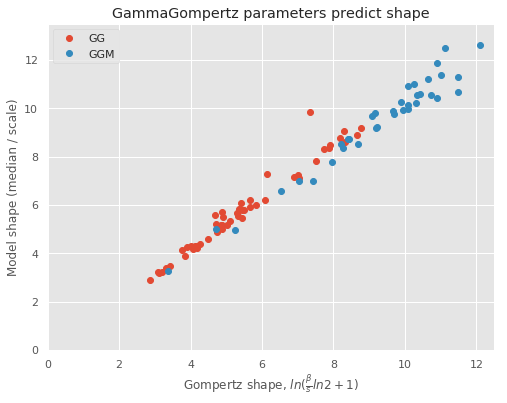

In [156]:
f, ( ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[strain_df['model_type']=='GG','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GG','shape_med'],'o',label='GG')
ax1.plot(strain_df.loc[strain_df['model_type']=='GGM','shape_eta'],
         strain_df.loc[strain_df['model_type']=='GGM','shape_med'],'o',label='GGM')
ax1.set_xlabel('Gompertz median')
ax1.set_ylabel('Model shape (median / scale)')
ax1.set_xlim([0,12.5])
ax1.set_ylim([0,13.5])
ax1.legend(loc=2)

ax1.set_xlabel(r'Gompertz shape, $ln(\frac{\beta}{s}ln2+1)$')

ax1.set_title('GammaGompertz parameters predict shape')

f.set_size_inches(8,6)

### 5.4 Shape and Gompertz intercept $\eta = \frac{\beta}{s}$

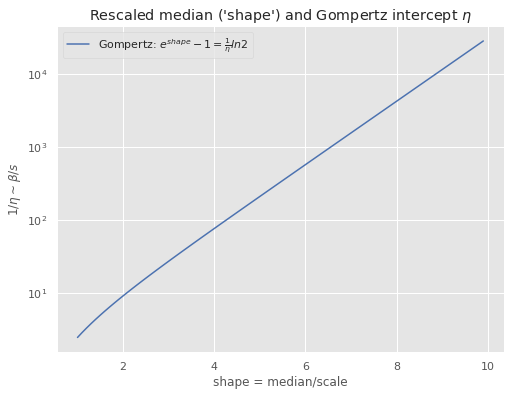

In [157]:
ax2 = plt.gca()
ax2.plot(np.arange(1,10,0.1), [(np.exp(s)-1)/np.log(2) for s in np.arange(1,10,0.1)], 'b',
         label=r'Gompertz: $e^{shape}-1 = \frac{1}{\eta}ln2$')
ax2.set_yscale('log')
ax2.set_ylabel('$1/\\eta \\sim \\beta/s$')
ax2.set_xlabel('shape = median/scale')
ax2.legend(loc=0)
ax2.set_title('Rescaled median (\'shape\') and Gompertz intercept $\eta$')

plt.gcf().set_size_inches(8,6)

## 6. Saving and replotting aging parameters using only initially selected mutants

### 6.0 Saving results so far

In [33]:
strain_df[['scale','scale_ratio','scale_ratio_log2','rate_overlap_wt',
           'med_exp','med_exp_overlap_wt','med_model','med_ratio','lifespan_ratio_log2',
           'shape_med','shape_med_overlap_wt','shape_exp','shape_eta','inverse_eta','shape_ratio_log2']].to_csv('/app/src/ms2_post_analysis/Aging parameters.csv')
strain_df[['scale_ratio_log2','scale','lifespan_ratio_log2','med_exp',
           'shape_ratio_log2','shape_exp',
           'rate_overlap_wt','med_exp_overlap_wt','shape_med_overlap_wt']].to_csv(
                '/app/src/ms2_post_analysis/Mutant effects on aging parameters.csv')

## waiting candidates

In [34]:
strain_df.loc[['MG-WT']+candidates, ['model type']+
              list(np.ravel([[trait,trait+'_L95%',trait+'_U95%'] for trait in ['rate','beta','s','lambda']]))].to_csv(
                'csv/Candidates aging parameters.csv')
strain_df.loc[['MG-WT']+candidates, ['model type']+
              list(np.ravel([[trait,trait+'_L95%',trait+'_U95%'] for trait in ['rate','beta','s','lambda']]))]

,model type,rate,rate_L95%,rate_U95%,beta,beta_L95%,beta_U95%,s,s_L95%,s_U95%,lambda,lambda_L95%,lambda_U95%
MG-WT,GGM,0.072927,0.061541,0.086420,1.537637e+02,8.521133e+01,2.774665e+02,0.956717,7.035788e-01,1.300931e+00,0.000656,0.000185,0.002323
yihV%202,GGM,0.067085,0.055060,0.081737,2.099468e+06,9.712218e-10,4.538372e+21,1299.646477,5.646206e-13,2.991533e+18,0.002739,0.001856,0.004041
norW,GGM,0.110475,0.101980,0.119678,3.732126e+04,1.900973e+04,7.327176e+04,0.609506,5.236367e-01,7.094567e-01,0.000369,0.000276,0.000492
norV,GGM,0.167343,0.148959,0.187995,2.196699e+07,3.831853e+06,1.259309e+08,0.328996,2.651946e-01,4.081466e-01,0.000318,0.000227,0.000445
yncI,GG,0.041144,0.039433,0.042931,1.296691e+04,1.074843e-02,1.564328e+10,298.713786,2.360493e-04,3.780139e+08,0.000000,0.000000,0.000000
yecP,GG,0.081422,0.073215,0.090548,8.196510e+03,4.564645e+03,1.471807e+04,5.031425,2.133545e+00,1.186534e+01,0.000000,0.000000,0.000000
bipA,GG,0.068770,0.062928,0.075155,2.286930e+02,1.780434e+02,2.937513e+02,0.756564,6.101239e-01,9.381513e-01,0.000000,0.000000,0.000000
pgi3,GGM,0.129150,0.111830,0.149152,1.136635e+07,2.052785e+06,6.293589e+07,1.503514,8.714803e-01,2.593925e+00,0.001856,0.001599,0.002154
nirC,GGM,0.138356,0.108627,0.176221,3.693520e+06,2.706145e+05,5.041152e+07,0.945353,4.070464e-01,2.195552e+00,0.000644,0.000448,0.000925
80%20MG%20yagS,GG,0.052707,0.051206,0.054252,1.359783e+05,1.118097e-02,1.653711e+12,1457.002715,1.169997e-04,1.814412e+10,0.000000,0.000000,0.000000


In [35]:
for strain in Fitted.keys():
    if strain in strain_error:
        print "jump ", strain
        continue
    quantiles[strain].to_csv('/app/src/ms2_post_analysis/bootstrap/'+strain+'.csv')

jump  ydjQ


### 6.1 Growth yields are only measured for the initially selected mutants

In [36]:
yield_df = pandas.read_csv('yield_all_strains.csv',sep=',')
yield_df.set_index('Unnamed: 0', inplace=True)

In [37]:
initial_genes = list(yield_df.index)
initial_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] in initial_genes]
other_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] not in initial_genes]
for strain in initial_strains:
    print strain
    strain_df.loc[strain, 'yield_mean'] = np.mean(np.mean(yield_df.loc[strain.split('_')[0], :]))
    strain_df.loc[strain, 'yield_std'] = np.mean(np.std(yield_df.loc[strain.split('_')[0], :]))


norW
norV
yncI
yecP
bipA
nirC
ycaL
ulaD
nagZ
sspA
nagK
ydjQ
MG-WT
yfbM
ptsH
ydjK
pfkA
dnaT
yjeL
gspF
gspL
paoB
yagQ
ybdG
fruR
ldcC
tyrB
fruB
phnH
ybaJ
ytfF
cbpM
caiT
yobH
yhbW
caiB
yhbS
dcp
recF
ygjP
glf
mhpB
gltL
fixC
gltD
ybbP
yggE
yggF
citT
yphG
napC
appB
appA
intG
pflD
pflC
ykfF
ykfI
yjhG
rsd
treC
agaR
yicH
agaV
yihS
tdcE
hycA
yiaW
yjgB
flu
eutQ
yqjE
crcA
xdhB
yagH
yidH
yjfC
fkpA
eptA
cynX
paaC
yhbP
idnD
nsrR
sgcQ
mtlD
ssuA
yeeW
cstA
yigL
yafX
yafV
yigZ


In [134]:
sns.set()

### 6.2 Three sub-types are outlined: mutants with wildtype level lifespan or aging scale or shape

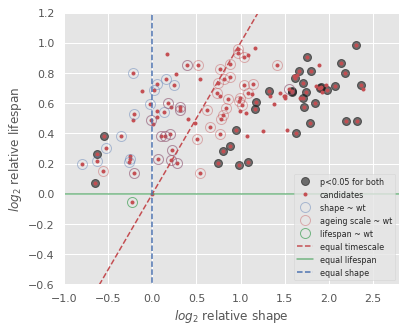

In [160]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.difference(set.intersection(set(initial_strains), shape_diff, lifespan_diff),rate_non),'shape_ratio_log2'], 
         strain_df.loc[set.difference(set.intersection(set(initial_strains), shape_diff, lifespan_diff),rate_non),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'shape_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, lifespan_non)), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, lifespan_non)), 'lifespan_ratio_log2'],
         'o',label='shape ~ wt',markerfacecolor='none', markeredgecolor='b', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'lifespan_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)


ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), 'r--', label='equal timescale')
ax1.plot(np.arange(4,-4,-0.1),[0]*80, '-',color='g', alpha=0.8, label='equal lifespan')
ax1.plot([0]*80,np.arange(4,-4,-0.1),  '--',color='b', label='equal shape')
ax1.legend(loc=4, fontsize=8)

ax1.set_ylim([-0.6,1.2])
ax1.set_xlim([-1,2.8])


f.set_size_inches(6,5)

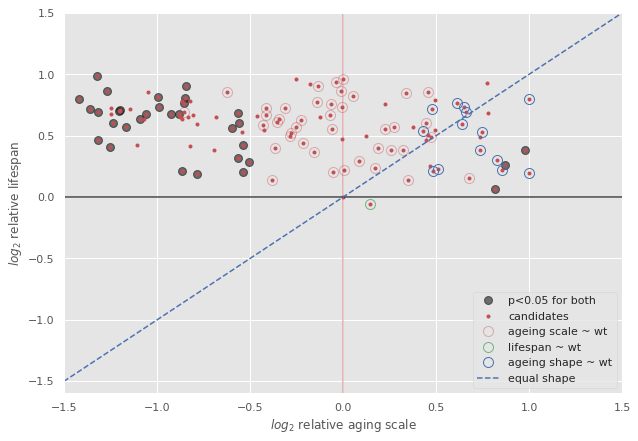

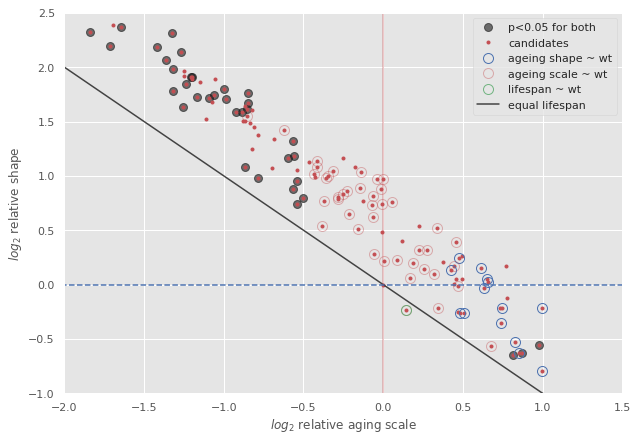

In [161]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)

rate_diff = set(strain_df.index[strain_df['rate_overlap_wt']!=0])
rate_non = set(strain_df.index[strain_df['rate_overlap_wt']==0])
lifespan_diff = set(strain_df.index[strain_df['med_exp_overlap_wt']!=0])
lifespan_non = set(strain_df.index[strain_df['med_exp_overlap_wt']==0])
shape_diff = set(strain_df.index[strain_df['shape_med_overlap_wt']!=0])
shape_non = set(strain_df.index[strain_df['shape_med_overlap_wt']==0])

f1, (ax1) = plt.subplots(1, sharex=False)
f2, (ax2) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff, shape_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff, shape_diff),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'lifespan_ratio_log2'],
         'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non), lifespan_diff), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non), lifespan_diff), 'lifespan_ratio_log2'],
        'o',label='ageing shape ~ wt',markerfacecolor='none', markeredgecolor='b', markersize=10)

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[set.intersection(set(initial_strains), shape_diff, rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), shape_diff, rate_diff, lifespan_diff),'shape_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax2.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'shape_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non)), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(shape_non, rate_non)), 'shape_ratio_log2'],
        'o',label='ageing shape ~ wt',markerfacecolor='none', markeredgecolor='b', markersize=10)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains), rate_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), rate_non), 'shape_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'shape_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '-',color='k', alpha=0.8, label='equal lifespan')
ax2.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--',color='b')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-2.0,1.5])
ax1.set_ylim([-1.6,1.5])
ax2.set_ylim([-1,2.5])


f2.set_size_inches(10,7)
f1.set_size_inches(10,7)

### 6.3 Only two sub-types are outlined: mutants with wildtype level lifespan or aging scale

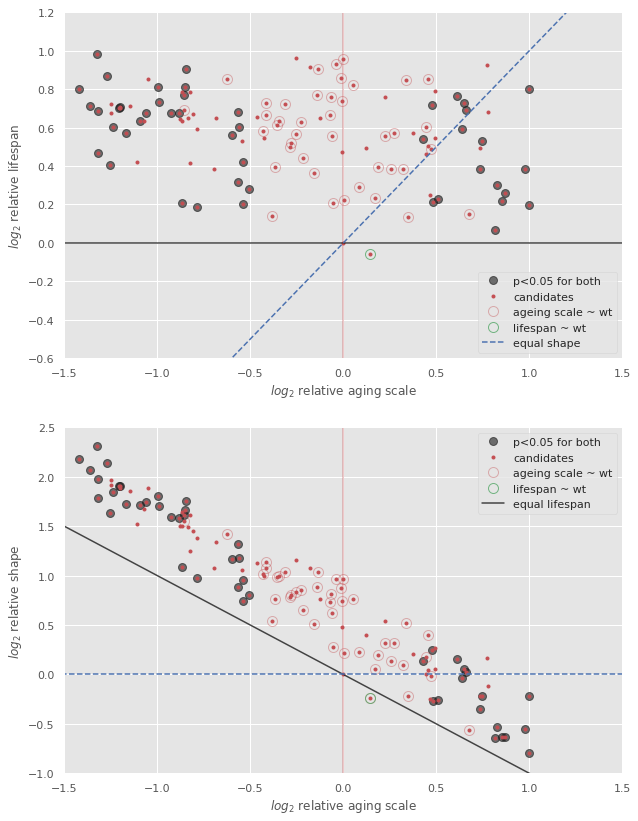

In [162]:
#candidates = ['ompL_new','pgi','uxaB_new','aqpZ','ascG','caiT_new','yagS','yfiD_new', 'appY']
candidates = list(strain_df.index)
rate_diff = set(strain_df.index[strain_df['rate_overlap_wt']!=0])
rate_non = set(strain_df.index[strain_df['rate_overlap_wt']==0])
lifespan_diff = set(strain_df.index[strain_df['med_exp_overlap_wt']!=0])
lifespan_non = set(strain_df.index[strain_df['med_exp_overlap_wt']==0])
shape_diff = set(strain_df.index[strain_df['shape_med_overlap_wt']!=0])
shape_non = set(strain_df.index[strain_df['shape_med_overlap_wt']==0])

f, (ax1, ax2) = plt.subplots(2, sharex=False)

ax1.plot(strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non, lifespan_non)), 'lifespan_ratio_log2'],
         'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'scale_ratio_log2'], 
         strain_df.loc[set.intersection(set(initial_strains), rate_diff, lifespan_diff),'shape_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax2.plot(strain_df.loc[candidates,'scale_ratio_log2'], 
         strain_df.loc[candidates,'shape_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains), rate_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), rate_non), 'shape_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax2.plot(strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'scale_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains),lifespan_non), 'shape_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)
ax2.set_xlabel('$log_2$ relative aging scale')
ax2.set_ylabel('$log_2$ relative shape ')
ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '-',color='k', alpha=0.8, label='equal lifespan')
ax2.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--',color='b')
ax2.legend(loc=1)

ax1.set_xlim([-1.5,1.5])
ax2.set_xlim([-1.5,1.5])
ax1.set_ylim([-0.6,1.2])
ax2.set_ylim([-1,2.5])


f.set_size_inches(10,14)

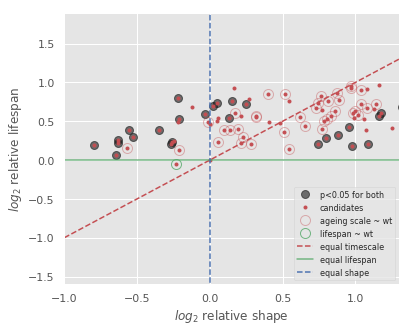

In [163]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set.difference(set.intersection(set(initial_strains), lifespan_diff),rate_non),'shape_ratio_log2'], 
         strain_df.loc[set.difference(set.intersection(set(initial_strains), lifespan_diff),rate_non),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
ax1.plot(strain_df.loc[candidates,'shape_ratio_log2'], 
         strain_df.loc[candidates,'lifespan_ratio_log2'],
         '.',label='candidates', color='r', markersize=6)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), set.difference(rate_non,lifespan_non)), 'lifespan_ratio_log2'],
        'o',label='ageing scale ~ wt',markerfacecolor='none', markeredgecolor='r', alpha=0.4, markersize=10)
ax1.plot(strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'shape_ratio_log2'],
         strain_df.loc[set.intersection(set(initial_strains), lifespan_non), 'lifespan_ratio_log2'],
         'o',label='lifespan ~ wt', markerfacecolor='none', markeredgecolor='g', alpha=0.8, markersize=10)


ax1.set_xlabel('$log_2$ relative shape')
ax1.set_ylabel('$log_2$ relative lifespan')
ax1.plot(np.arange(-1,1.5,0.1), np.arange(-1,1.5,0.1), 'r--', label='equal timescale')
ax1.plot(np.arange(4,-4,-0.1),[0]*80, '-',color='g', alpha=0.8, label='equal lifespan')
ax1.plot([0]*80,np.arange(4,-4,-0.1),  '--',color='b', label='equal shape')
ax1.legend(loc=4, fontsize=8)

ax1.set_ylim([-1.6,1.9])
ax1.set_xlim([-1,1.3])


f.set_size_inches(6,5)

# 7. Publication quality exhibitions of mutant lifespan distributions 

In [129]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style("white")

In [43]:
coordinates = dict()
for strain in initial_strains:
    coordinates[strain] = (strain_df.loc[strain,'scale_ratio_log2'], strain_df.loc[strain,'lifespan_ratio_log2'])
def distance(strain1, strain2):
    return np.sqrt(np.sum(np.power(coordinates[strain1][i]-coordinates[strain2][i], 2) for i in range(2)))

grid_positions = dict()
vectors = dict()
to_assign = set(initial_strains)
grid_positions['MG-WT']=(0,0)
#to_assign.remove('WT')
while len(to_assign) > 0:
    #finding the next strain to assign: closed to already assigned strains
    min_dist2grid = 99.0
    next_strain2assign = ''
    for strain in to_assign:
        dist2grid = np.min([distance(strain,assigned) for assigned in grid_positions.keys()])
        if dist2grid < min_dist2grid:
            next_strain2assign = strain
            min_dist2grid = dist2grid
    
    if next_strain2assign == '':
        break
    else:
        print next_strain2assign
        
    for assigned in grid_positions.keys():
        if distance(next_strain2assign,assigned) == min_dist2grid:
            #assign next_strain2assign next to its closest assignd neighbor
            dist_x = np.abs(coordinates[next_strain2assign][0]-coordinates[assigned][0])
            dist_y = np.abs(coordinates[next_strain2assign][1]-coordinates[assigned][1])
            
            if dist_x > dist_y:
                grid_positions[next_strain2assign] = (grid_positions[assigned][0], 
                                                      grid_positions[assigned][1]+
                                                     int((coordinates[next_strain2assign][1]-
                                                          coordinates[assigned][1])/
                                                         dist_y)
                                                     )
            else:
                try:
                    grid_positions[next_strain2assign] = (grid_positions[assigned][0]+
                                                        int((coordinates[next_strain2assign][0]-
                                                          coordinates[assigned][0])/dist_x), 
                                                      grid_positions[assigned][1])
                except:
                    grid_positions[next_strain2assign] = (0,0)
                    
            vectors[next_strain2assign] = (assigned, (coordinates[next_strain2assign][0]-coordinates[assigned][0],
                                    coordinates[next_strain2assign][1]-coordinates[assigned][1]))
            print assigned, grid_positions[assigned], '->', next_strain2assign, grid_positions[next_strain2assign],coordinates[next_strain2assign]
            to_assign.remove(next_strain2assign)
            
            
            
            

/app/miniconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/app/miniconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


MG-WT
MG-WT (0, 0) -> MG-WT (0, 0) (0.0, 0.0)
ycaL
MG-WT (0, 0) -> ycaL (0, -1) (0.1410646999463296, -0.057022304458653396)
ykfF
MG-WT (0, 0) -> ykfF (-1, 0) (-0.05665989646627258, 0.20635360578890183)
agaR
ykfF (-1, 0) -> agaR (-1, 1) (0.0028500740879576648, 0.22098748913361174)
bipA
agaR (-1, 1) -> bipA (-1, 2) (0.08467235949339617, 0.29059699513735454)
pflD
bipA (-1, 2) -> pflD (-1, 1) (0.17002891538303555, 0.23234232384423892)
treC
bipA (-1, 2) -> treC (0, 2) (0.18713640680095073, 0.39487846399662774)
agaV
treC (0, 2) -> agaV (0, 1) (0.256119367515842, 0.3844252410134848)
yeeW
agaV (0, 1) -> yeeW (0, 0) (0.3210516180450101, 0.3842342729389669)
eptA
treC (0, 2) -> eptA (1, 2) (0.2249161026085257, 0.5558264293081195)
dcp
eptA (1, 2) -> dcp (1, 3) (0.2725742060225542, 0.573073562964074)
hycA
dcp (1, 3) -> hycA (1, 2) (0.4282555192053177, 0.5379333381202505)
recF
hycA (1, 2) -> recF (2, 2) (0.4442741901988092, 0.6014312254215929)
gspL
hycA (1, 2) -> gspL (2, 2) (0.46909099049334413, 0.

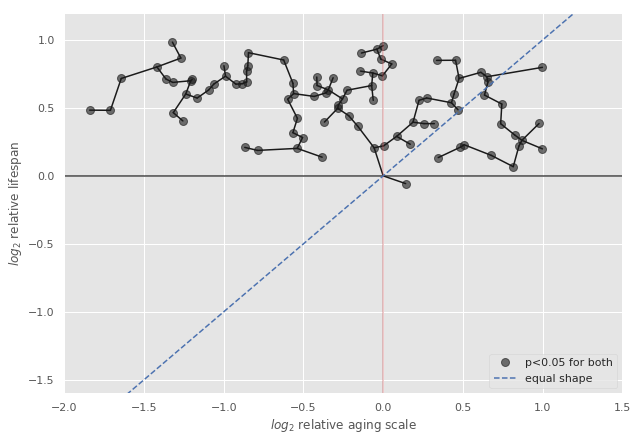

In [164]:
f, (ax1) = plt.subplots(1, sharex=False)

ax1.plot(strain_df.loc[set(initial_strains),'scale_ratio_log2'], 
         strain_df.loc[set(initial_strains),'lifespan_ratio_log2'],
         'o',label='p<0.05 for both', color='k', markersize=8, alpha=0.6)
for strain, (start, vector) in vectors.items():
    ax1.plot([coordinates[start][0], coordinates[strain][0]], [coordinates[start][1], coordinates[strain][1]], 'k-')

ax1.set_ylabel('$log_2$ relative lifespan')
ax1.set_xlabel('$log_2$ relative aging scale')
ax1.plot(np.arange(4,-4,-0.1), [0]*80, '-', color='k', alpha=0.8)
ax1.plot( [0]*80, np.arange(4,-4,-0.1), '-', color='r', alpha=0.4)
ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', color='b', label='equal shape')
ax1.legend(loc=4)

ax1.set_xlim([-2.0,1.5])
ax1.set_ylim([-1.6,1.2])

f.set_size_inches(10,7)

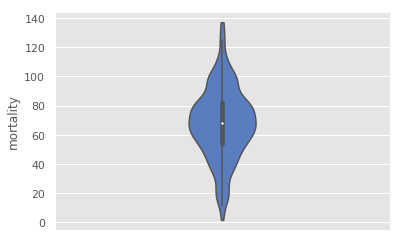

In [165]:
sns.violinplot(dfs_mortality['MG-WT']['mortality'],
               scale='area',cut=0,bw=0.2,gridsize=100,palette="muted",orient='v',
               width=0.2, inner='box')

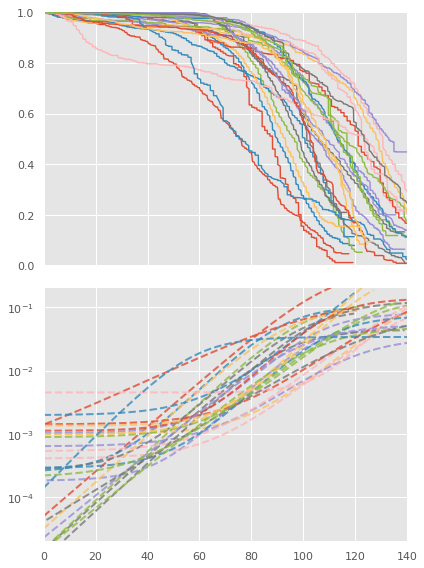

In [166]:
from cohortMortalitySummary import KaplanMeier, NelsonAalen, Breslow, BSHazardR, generate_ts_image
f, (ax1, ax3) = plt.subplots(2, 1, sharex=True, sharey=False)
for strain in list(set.intersection(set(initial_strains), shape_diff, rate_non)):
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    ax1.plot(KM.index,KM.loc[:,'survivorship'],linewidth=1.4)
    #ax1.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_survivorship'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
    #ax1.fill_between(KM.index,KM.loc[:,'lower_ci'],KM.loc[:,'upper_ci'],
    #                        alpha=0.3)
    #BSFit = BSFits[strain]
    #ax3.plot(BSFit['time'],BSFit['hazard'],linewidth=1.4)
    #ax3.fill_between(BSFit['time'],BSFit['lower.ci'],BSFit['upper.ci'],
    #                        alpha=0.5)
    ax3.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_hazard'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
ax1.set_ylim([0,1])
ax1.set_xlim([0,140])
ax3.set_yscale('log')
ax3.set_ylim([0.00002,0.2])
sns.despine()
f.set_size_inches(6,8)
plt.tight_layout()

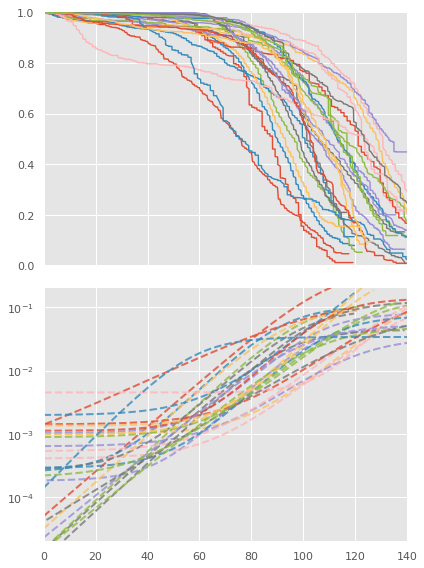

In [167]:
from cohortMortalitySummary import KaplanMeier, NelsonAalen, Breslow, BSHazardR, generate_ts_image
f, (ax1, ax3) = plt.subplots(2, 1, sharex=True, sharey=False)
for strain in list(set.intersection(set(initial_strains), shape_diff, rate_non)):
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    ax1.plot(KM.index,KM.loc[:,'survivorship'],linewidth=1.4)
    #ax1.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_survivorship'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
    #ax1.fill_between(KM.index,KM.loc[:,'lower_ci'],KM.loc[:,'upper_ci'],
    #                        alpha=0.3)
    #BSFit = BSHazardR(dfs_mortality[strain])
    #ax3.plot(BSFit['time'],BSFit['hazard'],linewidth=1.4)
    #ax3.fill_between(BSFit['time'],BSFit['lower.ci'],BSFit['upper.ci'],
    #                        alpha=0.5)
    ax3.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_hazard'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
ax1.set_ylim([0,1])
ax1.set_xlim([0,140])
ax3.set_yscale('log')
ax3.set_ylim([0.00002,0.2])
sns.despine()
f.set_size_inches(6,8)
plt.tight_layout()

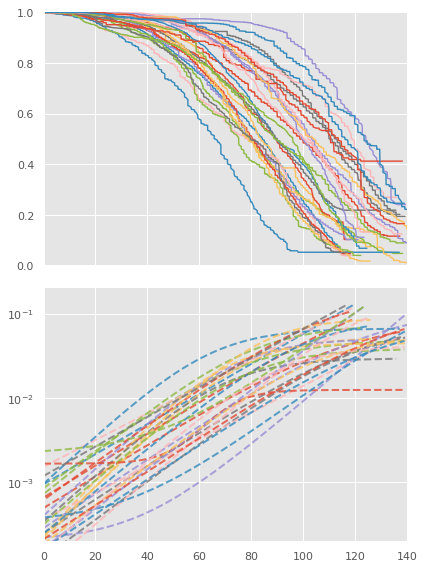

In [168]:
from cohortMortalitySummary import KaplanMeier, NelsonAalen, Breslow, BSHazardR, generate_ts_image
f, (ax1, ax3) = plt.subplots(2, 1, sharex=True, sharey=False)
for strain in list(set.intersection(set(initial_strains), shape_non)):
    KM = KaplanMeier(dfs_mortality[strain], tgs_mortality[strain])
    ax1.plot(KM.index,KM.loc[:,'survivorship'],linewidth=1.4)
    #ax1.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_survivorship'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
    #ax1.fill_between(KM.index,KM.loc[:,'lower_ci'],KM.loc[:,'upper_ci'],
    #                        alpha=0.3)
    #BSFit = BSFits[strain]
    #ax3.plot(BSFit['time'],BSFit['hazard'],linewidth=1.4)
    #ax3.fill_between(BSFit['time'],BSFit['lower.ci'],BSFit['upper.ci'],
    #                        alpha=0.5)
    ax3.plot(tgs_mortality[strain][1:],Fitted[strain]['ML_hazard'](tgs_mortality[strain][1:]),linewidth=2, linestyle='--',alpha=0.8)
ax1.set_ylim([0,1])
ax1.set_xlim([0,140])
ax3.set_yscale('log')
ax3.set_ylim([0.0002,0.2])
sns.despine()
f.set_size_inches(6,8)
plt.tight_layout()

# 8. Correlations between aging and growth parameters

### 8.1 Growth yields vs aging parameters

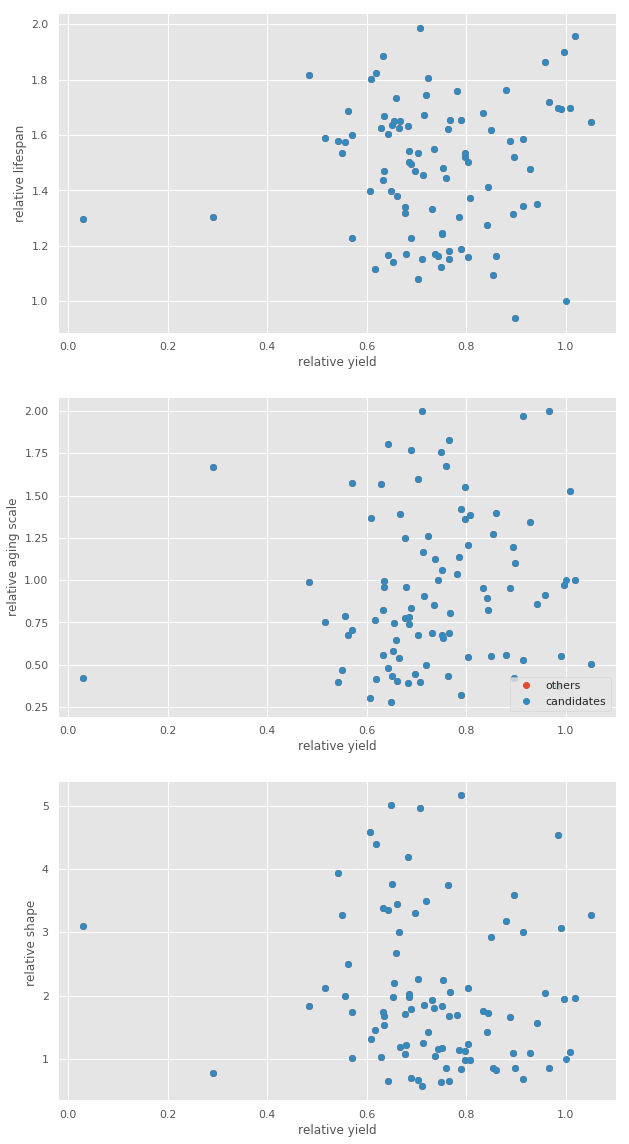

In [169]:
strain_df['yield_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','yield_mean']) for r in strain_df['yield_mean']]
strain_df['yield_ratio'] = [float(r)/strain_df.loc['MG-WT','yield_mean'] for r in strain_df['yield_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'scale_ratio'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'scale_ratio'], 'o', label='candidates')
ax1.set_ylabel('relative aging scale')
ax1.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'yield_ratio'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('relative yield')
ax2.set_ylabel('relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'med_ratio'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'med_ratio'], 'o', label='candidates')
ax3.set_ylabel('relative lifespan')
ax3.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

In [50]:
growth_curve_raw_df = pandas.read_csv('/Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/Growth Curves Raw Data MS1.csv',sep=';')
max_od = growth_curve_raw_df.iloc[0,1:]
for gene in max_od.index:
    value = float(max_od.loc[gene].replace(',','.'))
    if '.' not in gene:
        yield_df.loc[gene, 'R1'] = value - 0.044
    else:
        yield_df.loc[gene.split('.')[0], 'R'+str(int(gene.split('.')[1])+1)] = value - 0.044

IOError: File /Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/Growth Curves Raw Data MS1.csv does not exist

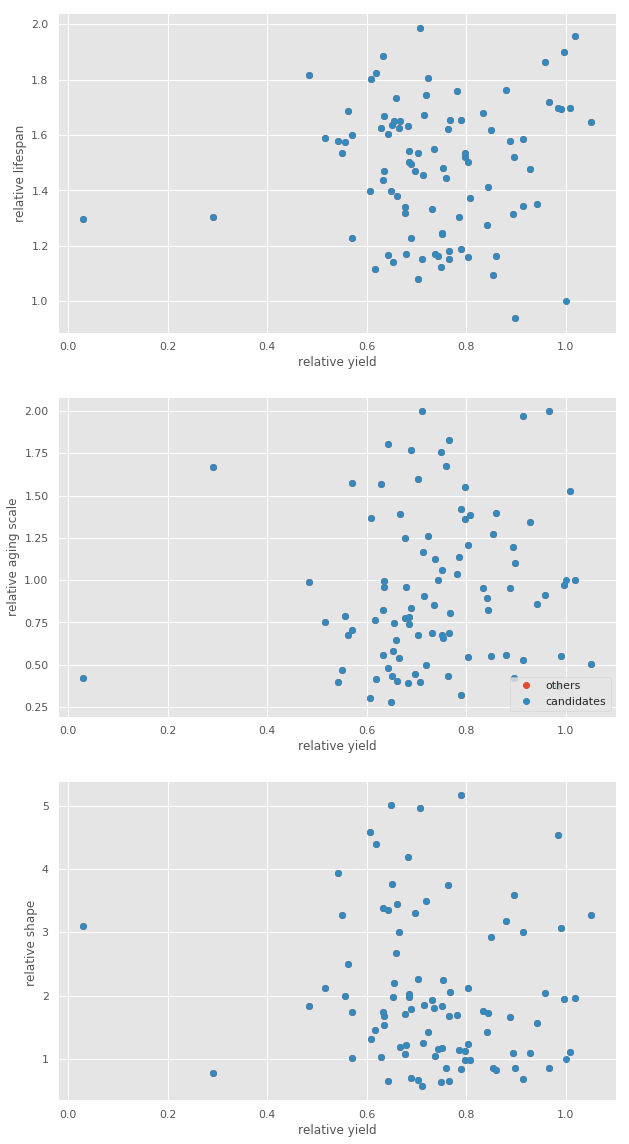

In [170]:
strain_df['yield_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','yield_mean']) for r in strain_df['yield_mean']]
strain_df['yield_ratio'] = [float(r)/strain_df.loc['MG-WT','yield_mean'] for r in strain_df['yield_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'scale_ratio'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'scale_ratio'], 'o', label='candidates')
ax1.set_ylabel('relative aging scale')
ax1.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
ax1.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'yield_ratio'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('relative yield')
ax2.set_ylabel('relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'yield_ratio'], 
         strain_df.loc[initial_strains, 'med_ratio'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'yield_ratio'],
         strain_df.loc[candidates, 'med_ratio'], 'o', label='candidates')
ax3.set_ylabel('relative lifespan')
ax3.set_xlabel('relative yield')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

### 8.2 Growth rates vs aging parameters

In [171]:
#grate_df = pandas.read_csv('/Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/Growth Rate of KO - Sheet1.csv',sep=',')
grate_df = pandas.read_csv('growth_rate_all_strains.csv',sep=',')

grate_df.set_index('Unnamed: 0', inplace=True)

initial_genes = list(grate_df.index)
initial_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] in initial_genes]
other_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] not in initial_genes]
for strain in initial_strains:
    strain_df.loc[strain, 'growr_mean'] = np.mean(np.mean(grate_df.loc[strain.split('_')[0], :]))
    strain_df.loc[strain, 'growr_std'] = np.mean(np.std(grate_df.loc[strain.split('_')[0], :]))

IOError: File growth_rate_all_strains.csv does not exist

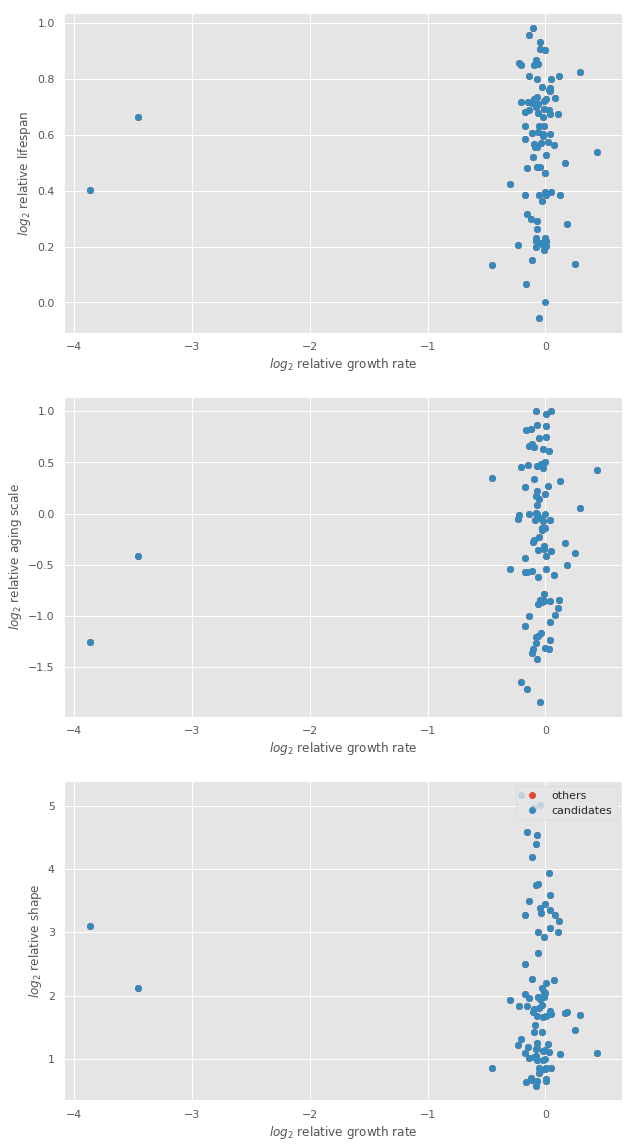

In [172]:
strain_df['growr_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','growr_mean']) for r in strain_df['growr_mean']]
strain_df['growr_ratio'] = [float(r)/strain_df.loc['MG-WT','growr_mean'] for r in strain_df['growr_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'scale_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'scale_ratio_log2'], 'o', label='candidates')
ax1.set_ylabel('$log_2$ relative aging scale')
ax1.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax2.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('$log_2$ relative growth rate')
ax2.set_ylabel('$log_2$ relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'lifespan_ratio_log2'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax3.set_ylabel('$log_2$ relative lifespan')
ax3.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

In [173]:
#grate_df_new = pandas.read_csv('/Users/yyfwuhan/Projects/2018-TaMaRa-Ana-figures/growth/growth_rate_max_xiaohu.csv',sep=',')


grate_df_new = pandas.read_csv('growth_rate_all_strains.csv',sep=',')

grate_dict = dict()
for i in range(len(grate_df_new)):
    name = grate_df_new.iloc[i,0]
    if grate_dict.has_key(name.split('-')[0]):
        grate_dict[name.split('-')[0]].append(grate_df_new.iloc[i,1])
    else:
        grate_dict[name.split('-')[0]] = [grate_df_new.iloc[i,1]]
initial_genes = list()
initial_strains = list()
for gene, grates in grate_dict.items():
    init_mean = np.mean(grates)
    init_std = np.std(grates)
    for gr in grates:
        if np.abs(gr - init_mean) > 2*init_std:
            print gene, gr, init_mean, init_std
            grates.remove(gr)
    if len(grates) != 0:
        try:
            initial_genes.append(gene)
            initial_strains.extend([strain for strain in strain_df.index if strain.split('_')[0] == gene])
            strain = initial_strains[-1]
            strain_df.loc[strain, 'growr_mean'] = np.mean(grates)
            strain_df.loc[strain, 'growr_std'] = np.std(grates)
        except:
            "error", gene, grates
        
other_strains = [strain for strain in strain_df.index
                   if strain.split('_')[0] not in initial_genes]

IOError: File growth_rate_all_strains.csv does not exist

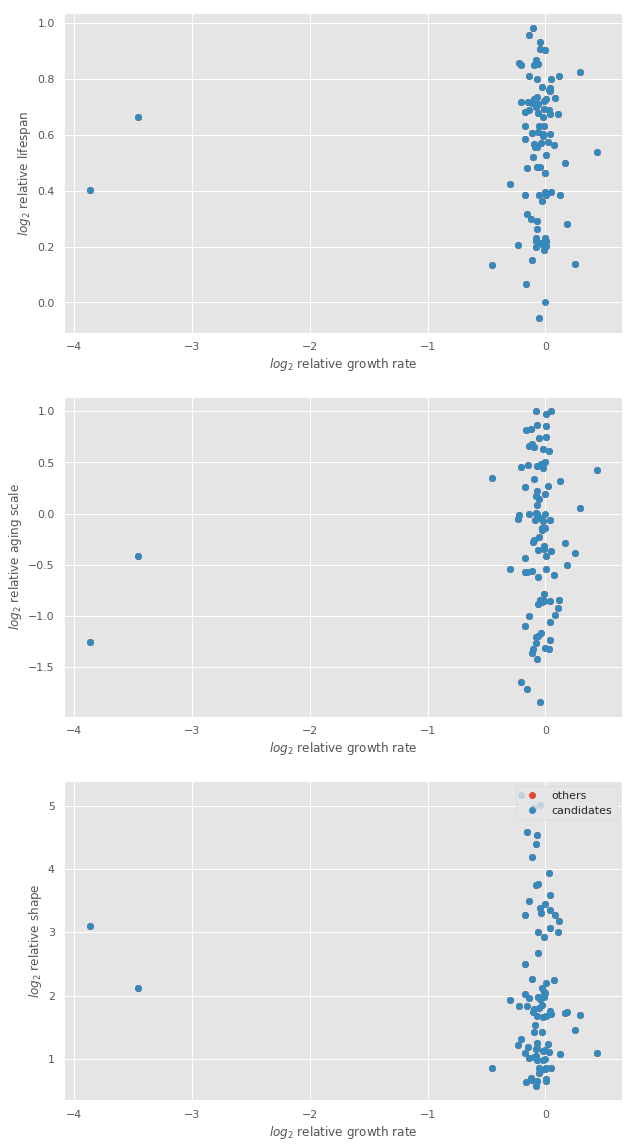

In [174]:
strain_df['growr_ratio_log2'] = [np.log2(float(r)/strain_df.loc['MG-WT','growr_mean']) for r in strain_df['growr_mean']]
strain_df['growr_ratio'] = [float(r)/strain_df.loc['MG-WT','growr_mean'] for r in strain_df['growr_mean']]

f, (ax3, ax1, ax2) = plt.subplots(3, sharex=False)

ax1.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'scale_ratio_log2'],
         'o',label='others')
ax1.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'scale_ratio_log2'], 'o', label='candidates')
ax1.set_ylabel('$log_2$ relative aging scale')
ax1.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax2.legend(loc=4)


ax2.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         np.power(2,strain_df.loc[initial_strains, 'shape_ratio_log2']),
         'o',label='others')
ax2.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         np.power(2,strain_df.loc[candidates, 'shape_ratio_log2']), 'o', label='candidates')
ax2.set_xlabel('$log_2$ relative growth rate')
ax2.set_ylabel('$log_2$ relative shape ')
#ax2.plot(np.arange(3,-4,-0.1), np.arange(-3,4,0.1), '--', label='equal lifespan')
#ax2.plot(np.arange(4,-4,-0.1), [0]*80, '--')
ax2.legend(loc=1)

#ax1.set_xlim([-1.5,1.5])
#ax2.set_xlim([-1.5,1.5])
#ax1.set_ylim([-1.6,0.9])
#ax2.set_ylim([-1,1.5])

ax3.plot(strain_df.loc[initial_strains, 'growr_ratio_log2'], 
         strain_df.loc[initial_strains, 'lifespan_ratio_log2'],
         'o',label='others')
ax3.plot(strain_df.loc[candidates, 'growr_ratio_log2'],
         strain_df.loc[candidates, 'lifespan_ratio_log2'], 'o', label='candidates')
ax3.set_ylabel('$log_2$ relative lifespan')
ax3.set_xlabel('$log_2$ relative growth rate')
#ax1.plot(np.arange(4,-4,-0.1), [0]*80, '--')
#ax1.plot(np.arange(2,-3,-0.1), np.arange(2,-3,-0.1), '--', label='equal shape')
#ax3.legend(loc=4)

f.set_size_inches(10,20)

### 8.3 Strains with extreme growth rates: are growth rate estimates correct?

In [56]:
strain_df.loc[strain_df['growr_ratio_log2']>1,['growr_ratio_log2','scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,growr_ratio_log2,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2


In [57]:
strain_df.loc[strain_df['growr_ratio_log2']<-0.75,['growr_ratio_log2','scale_ratio_log2','lifespan_ratio_log2','shape_ratio_log2']]

,growr_ratio_log2,scale_ratio_log2,lifespan_ratio_log2,shape_ratio_log2
ygjP,-3.455067,-0.414734,0.664650,1.081690
yihS,-3.867854,-1.256448,0.404245,1.633011
